In [31]:
#Basic imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing

In [17]:
# Import data
#df = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
df_new = pd.read_excel('data2.xlsx','voxels_per_AAL', header=[4])
df_labels = pd.read_excel('data2_labels.xlsx', header = 0)
df_labels = df_labels.rename(columns={ 'ID': 'Subject ID'})
subject_ids = df_labels.iloc[:,0]
df_labels = df_labels.rename(columns={ 'Gender (1: Male)': 'Gender'})
df_labels = df_labels.drop(['Date of birth', 'Date of MRI scan'], axis=1)

In [25]:
df_new2 = df_new.merge(df_labels, on='Subject ID')
df_new2 = df_new2.drop('Subject ID', axis=1)
filename = "data_concat.xlsx"
df_new2.to_excel(filename)

In [10]:
def clean_data2(df):
    X = df.copy()
    # Remove columns with only zeros
    X = X.loc[:, (X != 0).any(axis=0)]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace nan values by mean of column
    X = X.fillna(X.mean())
                 
    # Replace Sex labels by values
    X['Sex'].replace({0:'Male', 1:'Female'}, inplace=True)
    
    # Remove useless columns
    X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    
    # Split Sex in Sex_Female and Sex_Male
    X = pd.get_dummies(X)
    
    return X

In [11]:
def scale_data(df):
    X = df.copy()
    # Categorical values
    cater = X[['Sex_Female', 'Sex_Male']]
    # Numerical values
    numer = X.drop(['Sex_Female', 'Sex_Male'], axis=1)
    #Initialize our scaler
    scaler = StandardScaler()
    #Scale each column in numer
    numer = pd.DataFrame(scaler.fit_transform(numer), columns=numer.columns)
    
    X_scaled = pd.concat([numer, cater], axis=1, join='inner')
    return X_scaled

In [12]:
X = clean_data2(df)
X_scaled = scale_data(X)

#### Plot function

In [13]:
def plot_results(y_train, y_test, predict_train, predict_test, params, model):
    pp = PdfPages(f'{model}.pdf')
    params = ", ".join("=".join([key, str(value)]) for key, value in params.items())
    
    # Plot
    plt.figure(figsize=(10,10))
    plt.scatter(np.array(y_train, dtype='int'), predict_train, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predict_train), max(y_train))
    p2 = min(min(predict_train), min(y_train))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.title(f'{model}({params})')
    plt.xlabel('Train True Age', fontsize=15)
    plt.ylabel('Train Predicted Age', fontsize=15)
    plt.axis('equal')
    pp.savefig(plt.gcf(), bbox_inches='tight')
    plt.show()


     # Plot
    plt.figure(figsize=(10,10))
    plt.scatter(np.array(y_test, dtype='int'), predict_test, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predict_test), max(y_test))
    p2 = min(min(predict_test), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.title(f'{model}({params})')
    plt.xlabel('Test True Age', fontsize=15)
    plt.ylabel('Test Predicted Age', fontsize=15)
    plt.axis('equal')
    pp.savefig(plt.gcf(), bbox_inches='tight')
    plt.show()
    
    pp.close()

# K-Means

In [14]:
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer

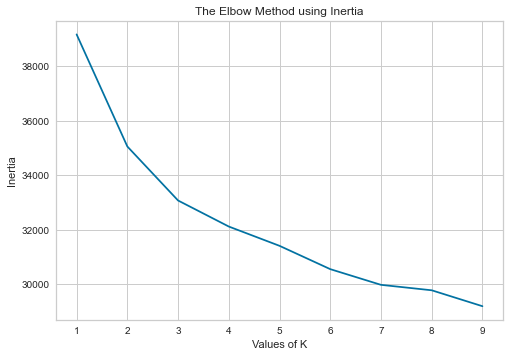

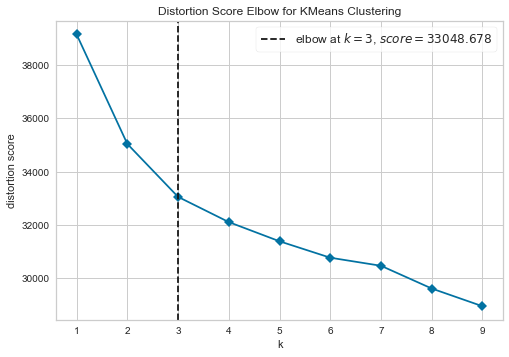

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
K = range(1, 10)
inertias = []
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_scaled)
    inertias.append(kmeanModel.inertia_)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=K, timings=False)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [16]:
kmeanModel = KMeans(n_clusters=3).fit(X_scaled)
X_scaled.insert(0, value=kmeanModel.labels_, column='Cluster')

# K Nearest Neighbors

In [33]:
df_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Columns: 172 entries, Left Precentral gyrus to Age
dtypes: int64(172)
memory usage: 313.6 KB


In [34]:
df_new2.describe()

,Left Precentral gyrus,Right Precentral gyrus,Left Superior frontal gyrus-dorsolateral,Right Superior frontal gyrus-dorsolateral,Left Middle frontal gyrus,Right Middle frontal gyrus,Left Inferior frontal gyrus-opercular part,Right Inferior frontal gyrus-opercular part,Left Inferior frontal gyrus-triangular part,Right Inferior frontal gyrus-triangular part,...,Lobule IV-V of vermis,Lobule VI of vermis,Lobule VII of vermis,Lobule VIII of vermis,Lobule IX of vermis,Lobule X of vermis,Raphe nucleus-dorsal,Raphe nucleus-median,Gender,Age
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,21015.288793,19178.543103,28179.237069,29211.780172,30692.103448,32018.159483,6959.987069,8543.142241,14981.250000,12499.008621,...,4424.956897,2798.284483,1599.491379,2188.379310,1935.469828,298.620690,251.806034,93.543103,1.655172,60.612069
std,2175.016845,2061.316645,2923.547436,3148.635568,3106.731727,3805.998238,687.730035,904.348763,1589.227158,1357.816196,...,549.219736,366.499631,190.016495,235.312601,197.253279,119.028583,26.485990,12.854088,0.476340,4.844368
min,15149.000000,13561.000000,20051.000000,21909.000000,23939.000000,22683.000000,5363.000000,6470.000000,11482.000000,8662.000000,...,3137.000000,1910.000000,1016.000000,1530.000000,1441.000000,56.000000,184.000000,64.000000,1.000000,50.000000
25%,19566.750000,17719.750000,26355.750000,27217.250000,28754.000000,29833.500000,6486.000000,7919.000000,13862.250000,11660.750000,...,4074.000000,2558.250000,1464.750000,2029.000000,1793.000000,212.750000,233.000000,84.000000,1.000000,56.750000
50%,20991.000000,19190.500000,27843.000000,28954.000000,30353.000000,31689.500000,6870.000000,8556.000000,14824.500000,12456.000000,...,4342.000000,2795.000000,1605.000000,2162.500000,1930.500000,290.000000,249.000000,94.000000,2.000000,61.000000
75%,22371.750000,20460.250000,30124.500000,31079.250000,32825.750000,34376.500000,7440.000000,9095.750000,16079.750000,13304.000000,...,4796.250000,3003.750000,1730.000000,2322.500000,2053.250000,375.250000,268.250000,103.000000,2.000000,65.000000
max,27296.000000,26190.000000,39326.000000,40961.000000,40420.000000,45553.000000,9287.000000,10977.000000,20258.000000,17860.000000,...,5878.000000,3986.000000,2076.000000,2989.000000,2475.000000,634.000000,331.000000,128.000000,2.000000,73.000000


In [70]:
#Separating the feature matrix and labels:
X = df_new2.drop('Age', axis=1).values
y = df_new2['Age'].values

In [71]:
#Function for data standardization:
def standardScaler(features):
    """Takes the numpy.ndarray object containing the features and performs standardization on the matrix.
    The function iterates through each column and performs scaling on each column individually.
    
    Args-
        features - Numpy array containing training features
        
    Returns-
        features - Standardized feature set
    """
    
    total_cols = features.shape[1]
    for i in range(total_cols):
        feature_col = features[:,i]
        mean = feature_col.mean()
        std = feature_col.std()
        features[:,i] = (features[:,i] - mean) / std
    return features

In [72]:
#Performing standardization on our feature set
features_scaled = standardScaler(X)

C:\Users\manon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='count'>

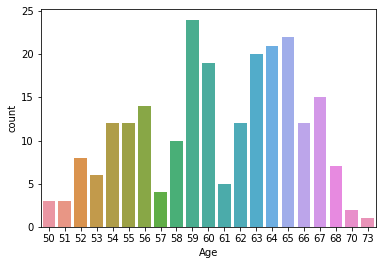

In [73]:
sns.countplot('Age', data=df_new2)

Observations: 
- Ages range from 50 to 73
- Most patients are between 59 and 67 years old. The data is suffering from sampling bias, where the patients who had MRI scans of their brains were mostly elderly subjects. There are no subjects younger than 50.
- A model trained on such data will produce biases results, where it is more likely to classify a patient as a 59-67 year old as compared to 50 or 73 for example. 

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train,X_test,y_train,y_test = train_test_split(features_scaled,y,test_size=0.4,random_state=42)

In [76]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,20)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

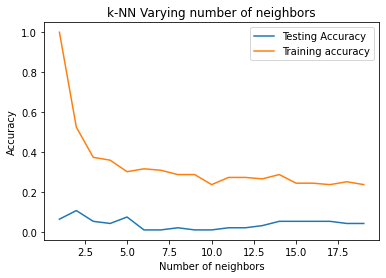

In [77]:
#Plot accuracy for different number of neighbors
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

We can observe that we obtain the maximum testing accuracy with k=2 or k=5 or k=13 (k=2 is slightly higher, but we will implement all three).

**2-nearest neighbors:**

In [78]:
#Setup a knn classifier with k=2 neighbors
knn = KNeighborsClassifier(n_neighbors=2)

In [79]:
#Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [80]:
#Get accuracy
knn.score(X_test,y_test)

0.10752688172043011

*Confusion matrix:*
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [81]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix

In [82]:
#we get the predictions for the test data using the classifier we had fit above
y_pred = knn.predict(X_test)

In [83]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,50,52,53,54,55,56,57,58,59,60,61,62,63,64,66,All
True,,,,,,,,,,,,,,,,
50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
51,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,3
52,0,0,0,2,1,1,0,0,2,0,0,0,0,0,0,6
53,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2
54,0,0,0,1,0,1,1,0,2,1,0,0,0,0,0,6
55,1,1,0,0,1,1,0,0,1,0,1,0,0,0,0,6
56,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,6
57,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,3
58,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,4


*Classification report:*

In [84]:
#import classification_report
from sklearn.metrics import classification_report

In [85]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         3
          52       0.00      0.00      0.00         6
          53       0.00      0.00      0.00         2
          54       0.20      0.17      0.18         6
          55       0.08      0.17      0.11         6
          56       0.07      0.17      0.10         6
          57       0.50      0.33      0.40         3
          58       0.50      0.25      0.33         4
          59       0.00      0.00      0.00         7
          60       0.40      0.20      0.27        10
          61       0.00      0.00      0.00         1
          62       0.00      0.00      0.00         5
          63       0.00      0.00      0.00         4
          64       0.50      0.25      0.33        12
          65       0.00      0.00      0.00        10
          66       0.00      0.00      0.00         1
          67       0.00    

C:\Users\manon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**5-nearest neighbors:**

In [86]:
#Setup a knn classifier with k=5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

In [87]:
#Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [88]:
#Get accuracy
knn.score(X_test,y_test)

0.07526881720430108

**13-nearest neighbors:**

In [89]:
#Setup a knn classifier with k=13 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

In [90]:
#Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [91]:
#Get accuracy
knn.score(X_test,y_test)

0.07526881720430108

**Cross validation:**

In [92]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [93]:
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}

In [94]:
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

C:\Users\manon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [95]:
knn_cv.best_score_

0.09935245143385754

In [96]:
knn_cv.best_params_

{'n_neighbors': 8}

A knn classifier with 8 neighbors achieves the best score using cross validation. Accuracy with k=8 : about 10%. This accuracy score is very low and therefore, a KNN classifier is probably not the best way to classify the data. Perhaps we can try implementing it again after dimensionality reduction (PCA).

# PCA

In [27]:

from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=10)

pc = pca.fit_transform(X_scaled.drop(['Sex_Female', 'Sex_Male'], axis=1))

In [29]:
X_scaled

,Cluster,Age,[norm] Brain tissue total volume,[norm] 3rd ventricle total volume,[norm] 4th ventricle total volume,[norm] Accumbens area right volume,[norm] Accumbens area left volume,[norm] Amygdala right volume,[norm] Amygdala left volume,[norm] Brain stem total volume,...,[norm] Hippocampus ROI total CN similarity,[norm] Hippocampus ROI total AD similarity,[norm] Hippocampus ROI total FTLD similarity,[norm] Hippocampus ROI total DLB similarity,[norm] Frontal ROI total CN similarity,[norm] Frontal ROI total AD similarity,[norm] Frontal ROI total FTLD similarity,[norm] Frontal ROI total DLB similarity,Sex_Female,Sex_Male
0,2,1.287748,0.480922,-0.663050,0.362989,0.415506,1.021022,0.361992,0.399141,-0.429232,...,0.537622,-0.326933,-0.912154,0.519301,-0.381228,-0.015282,-0.070934,0.812243,1,0
1,1,-0.134764,-0.784529,-0.429414,-1.784112,-1.039827,-1.084120,-2.792113,-1.700631,0.797189,...,0.699067,-0.264156,0.060779,-1.157361,-1.680973,-0.072236,1.356935,1.322242,1,0
2,0,-0.419267,-1.049110,1.129154,-0.079246,-0.404751,-0.602015,0.191827,0.193500,0.135211,...,0.000000,1.147044,0.987424,0.204174,-1.682114,1.526454,0.636389,-0.707151,0,1
3,0,2.710261,-1.537504,-0.609169,-1.747616,0.197424,-0.126281,-0.997851,0.244028,-0.315262,...,-1.154290,0.637910,0.190330,0.872108,-0.206695,-0.013672,0.526804,-0.317394,1,0
4,1,1.572251,-0.539561,1.995059,2.852872,-0.500203,0.275641,1.684504,0.147393,0.789115,...,-1.093302,1.717189,-0.431916,-1.226076,-0.997548,0.945069,0.350360,-0.457634,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,1,0.718743,-0.934361,0.442417,1.113246,0.398311,1.810035,0.326330,1.161226,-1.363788,...,-0.303738,1.176499,-1.445711,-0.583364,-0.058272,0.740849,-0.336452,-0.832907,1,0
129,1,-0.134764,-0.046796,0.178249,1.232042,-1.211324,-0.404699,-0.443263,-0.112599,-0.783148,...,-0.848008,0.069538,-1.109103,3.069540,1.018450,-0.443162,-0.476992,-0.353085,1,0
130,1,-0.134764,-0.188526,-0.991722,0.979995,0.226590,-0.072706,-0.240984,-0.065529,2.043577,...,0.075629,0.410499,-0.223585,-1.013326,0.046133,0.919470,-1.617052,0.382257,0,1
131,0,-0.134764,-2.646636,1.463071,-0.487266,0.011691,0.467150,-0.202663,-1.297979,-0.636238,...,-1.375783,0.955452,-0.378464,1.276074,-1.243540,-0.721939,1.211368,1.954965,1,0


In [30]:
df = pd.DataFrame(data = pc, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

target = X_scaled['Cluster']

result_df = pd.concat([df, target], axis=1)
result_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Cluster
0,0.474588,4.061781,-3.372415,-2.352141,5.997576,-3.070630,-1.139057,0.348581,-2.087365,-1.322973,2
1,6.360449,-7.880554,0.108728,5.092843,1.251373,4.567336,4.366607,-0.645035,-4.025794,1.394358,1
2,8.172366,4.662512,5.279666,-6.791686,-2.998180,9.244765,3.288412,-3.145375,1.188026,5.345241,0
3,7.589654,6.478352,-3.470282,-2.077512,14.186274,-1.333596,2.025702,-2.512370,-0.051245,3.377491,0
4,0.901592,-2.507186,1.545268,-6.855153,-4.749269,-0.919781,-0.154755,-0.563465,-4.239641,-0.613904,1


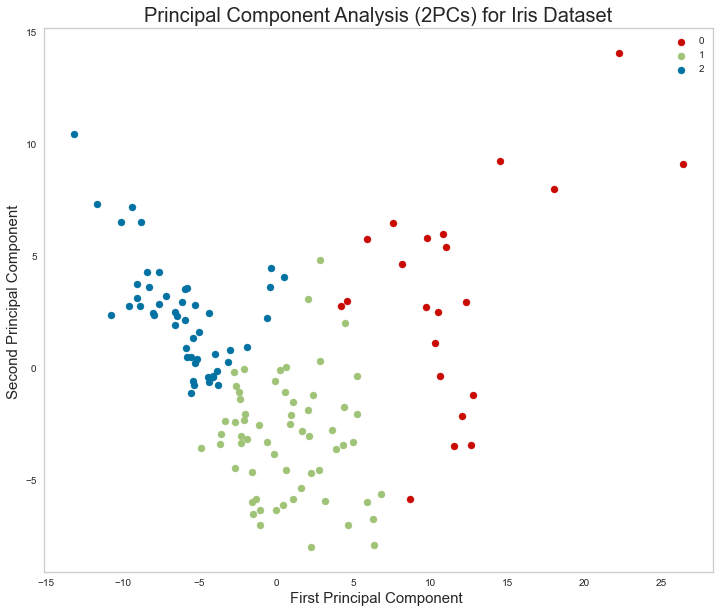

In [31]:
# Visualize Principal Components with a scatter plot
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('First Principal Component ', fontsize = 15)
ax.set_ylabel('Second Principal Component ', fontsize = 15)
ax.set_title('Principal Component Analysis (2PCs) for Iris Dataset', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = result_df['Cluster'] == target
    ax.scatter(result_df.loc[indicesToKeep, 'PC1'], 
               result_df.loc[indicesToKeep, 'PC2'],
               c = color, 
               s = 50)
ax.legend(targets)
ax.grid()

[None, None]

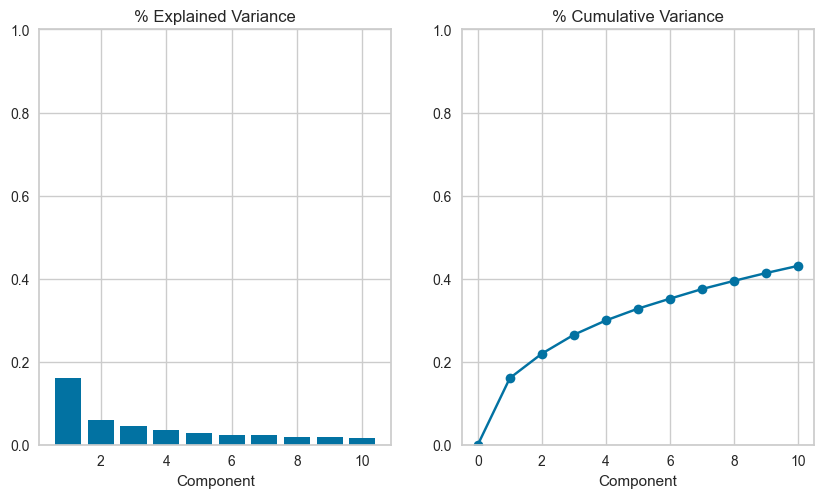

In [32]:
# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)
# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)
# Cumulative Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
# Set up figure
fig.set(figwidth=10, dpi=100)

In [89]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(pc, X['Age', discrete_features=False])

(133, 10)


# Elastic Net

In [ ]:
# Visualize Principal Components with a scatter plot
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('First Principal Component ', fontsize = 15)
ax.set_ylabel('Second Principal Component ', fontsize = 15)
ax.set_title('Principal Component Analysis (2PCs) for Iris Dataset', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = iris['target'] == target
    ax.scatter(result_df.loc[indicesToKeep, 'PC1'], 
               result_df.loc[indicesToKeep, 'PC2'], 
               c = color, 
               s = 50)
ax.legend(targets)
ax.grid()

In [43]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings("ignore")

In [8]:
x = X_scaled.drop(['Age'], axis=1)
y = X['Age']

### Grid Search - Polynomial Features

In [54]:
poly = PolynomialFeatures(2)
poly_x = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(poly_x, y, test_size=0.3, random_state=42)

# Define pipeline
pipe = Pipeline(steps=[
    ('select', SelectKBest(f_regression, k=10)),
    ('elastic', ElasticNet())
])

# Define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# Define grid
grid = {
    'select__k': [10, 50, 1000, 10000, 'all'],
    #'select__k': [500, 2000, 10000, 'all'],
    'elastic__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'elastic__l1_ratio': np.logspace(-4, 0, 6)
}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    search_elastic = GridSearchCV(pipe, grid, cv=cv, n_jobs=3, verbose=1, scoring='neg_mean_absolute_error')
search_elastic.fit(x_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_sele

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x15ec01a60>)),
                                       ('elastic', ElasticNet())]),
             n_jobs=3,
             param_grid={'elastic__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'elastic__l1_ratio': array([1.00000000e-04, 6.30957344e-04, 3.98107171e-03, 2.51188643e-02,
       1.58489319e-01, 1.00000000e+00]),
                         'select__k': [10, 50, 1000, 10000, 'all']},
             scoring='neg_mean_absolute_error', verbose=1)

In [55]:
print(search_elastic.best_estimator_)
print(search_elastic.best_score_)

Pipeline(steps=[('select',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x15ec01a60>)),
                ('elastic',
                 ElasticNet(alpha=0.001, l1_ratio=0.15848931924611143))])
-2.6357700753170064


(133, 44253)
[k=all, alpha=0.001, l1_ratio=0.15848931924611143] train_score: 0.0003994233612747995
[k=all, alpha=0.001, l1_ratio=0.15848931924611143] test_score: 2.473532815136815


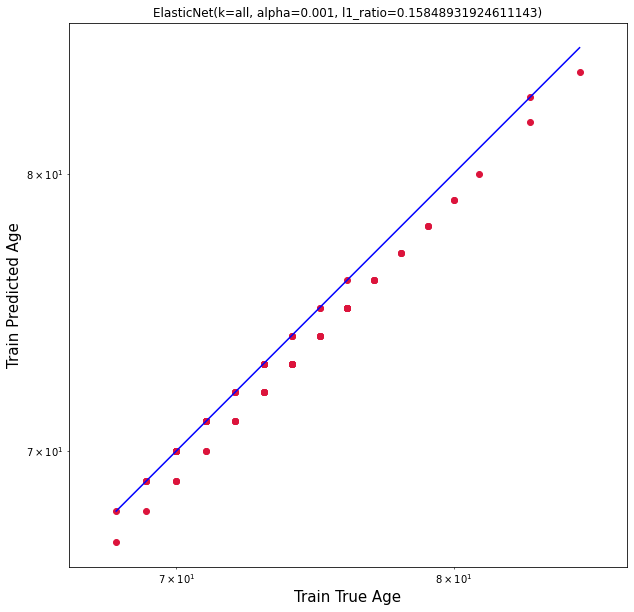

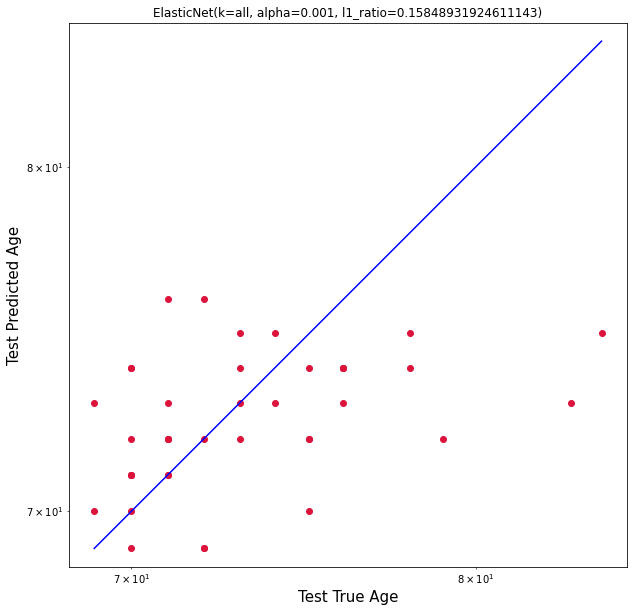

In [56]:
print(poly_x.shape)

elastic_best = search_elastic.best_estimator_

# Predict age
predict_train = elastic_best.predict(x_train)
predict_test = elastic_best.predict(x_test)

# Compute error
train_error = predict_train - y_train
test_error = predict_test - y_test

train_score = mean_absolute_error(y_train, predict_train)
test_score = mean_absolute_error(y_test, predict_test)

print(f'[k={elastic_best.steps[0][1].get_params()["k"]}, alpha={elastic_best.steps[1][1].get_params()["alpha"]}, l1_ratio={elastic_best.steps[1][1].get_params()["l1_ratio"]}] train_score: {train_score}')
print(f'[k={elastic_best.steps[0][1].get_params()["k"]}, alpha={elastic_best.steps[1][1].get_params()["alpha"]}, l1_ratio={elastic_best.steps[1][1].get_params()["l1_ratio"]}] test_score: {test_score}')

plot_results(y_train, y_test, predict_train, predict_test, {
    'k': elastic_best.steps[0][1].get_params()["k"],
    'alpha': elastic_best.steps[1][1].get_params()["alpha"],
    'l1_ratio': elastic_best.steps[1][1].get_params()["l1_ratio"]
}, 'ElasticNet')

# Random Forest

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from matplotlib.backends.backend_pdf import PdfPages

## Grid Search - Polynomial Features

In [36]:
poly = PolynomialFeatures(2)
poly_x = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(poly_x, y, test_size=0.3, random_state=42)

# Define pipeline
forest_pipe = Pipeline(steps=[
    ('select', SelectKBest(f_regression, k=10)),
    ('regressor', RandomForestRegressor(random_state=42))
])

grid = {
    'select__k': [50, 1000, 'all'],
    'regressor__max_depth': [5, 10, 15]
}
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

random_forest_search = GridSearchCV(forest_pipe, grid, cv=cv, n_jobs=1, verbose=10, scoring='neg_mean_absolute_error')
random_forest_search.fit(x_train, y_train)

Fitting 15 folds for each of 9 candidates, totalling 135 fits
[CV 1/15; 1/9] START regressor__max_depth=5, select__k=50.......................
[CV 1/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-3.835 total time=   0.2s
[CV 2/15; 1/9] START regressor__max_depth=5, select__k=50.......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 2/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-3.024 total time=   0.2s
[CV 3/15; 1/9] START regressor__max_depth=5, select__k=50.......................
[CV 3/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.275 total time=   0.1s
[CV 4/15; 1/9] START regressor__max_depth=5, select__k=50.......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 4/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.193 total time=   0.2s
[CV 5/15; 1/9] START regressor__max_depth=5, select__k=50.......................
[CV 5/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.500 total time=   0.1s
[CV 6/15; 1/9] START regressor__max_depth=5, select__k=50.......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 6/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.652 total time=   0.2s
[CV 7/15; 1/9] START regressor__max_depth=5, select__k=50.......................
[CV 7/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-3.381 total time=   0.2s
[CV 8/15; 1/9] START regressor__max_depth=5, select__k=50.......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 8/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-3.210 total time=   0.2s
[CV 9/15; 1/9] START regressor__max_depth=5, select__k=50.......................
[CV 9/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.920 total time=   0.2s
[CV 10/15; 1/9] START regressor__max_depth=5, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 10/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.201 total time=   0.2s
[CV 11/15; 1/9] START regressor__max_depth=5, select__k=50......................
[CV 11/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.918 total time=   0.1s
[CV 12/15; 1/9] START regressor__max_depth=5, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 12/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-3.096 total time=   0.2s
[CV 13/15; 1/9] START regressor__max_depth=5, select__k=50......................
[CV 13/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.487 total time=   0.2s
[CV 14/15; 1/9] START regressor__max_depth=5, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 14/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-3.342 total time=   0.2s
[CV 15/15; 1/9] START regressor__max_depth=5, select__k=50......................
[CV 15/15; 1/9] END regressor__max_depth=5, select__k=50;, score=-2.118 total time=   0.2s
[CV 1/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 1/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-3.557 total time=   0.7s
[CV 2/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 2/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-3.065 total time=   0.7s
[CV 3/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 3/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.088 total time=   0.7s
[CV 4/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 4/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.688 total time=   0.7s
[CV 5/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 5/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.745 total time=   0.7s
[CV 6/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 6/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.496 total time=   0.7s
[CV 7/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 7/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-3.142 total time=   0.7s
[CV 8/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 8/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-3.448 total time=   0.7s
[CV 9/15; 2/9] START regressor__max_depth=5, select__k=1000.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 9/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-3.024 total time=   0.7s
[CV 10/15; 2/9] START regressor__max_depth=5, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 10/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-1.677 total time=   0.7s
[CV 11/15; 2/9] START regressor__max_depth=5, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 11/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.838 total time=   0.7s
[CV 12/15; 2/9] START regressor__max_depth=5, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 12/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.923 total time=   0.7s
[CV 13/15; 2/9] START regressor__max_depth=5, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 13/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.247 total time=   0.7s
[CV 14/15; 2/9] START regressor__max_depth=5, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 14/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-3.067 total time=   0.7s
[CV 15/15; 2/9] START regressor__max_depth=5, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 15/15; 2/9] END regressor__max_depth=5, select__k=1000;, score=-2.387 total time=   0.7s
[CV 1/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 1/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-3.760 total time=  29.4s
[CV 2/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 2/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.826 total time=  26.8s
[CV 3/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 3/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.204 total time=  28.4s
[CV 4/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 4/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.652 total time=  27.1s
[CV 5/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 5/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.404 total time=  26.1s
[CV 6/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 6/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.317 total time=  25.7s
[CV 7/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 7/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.946 total time=  26.7s
[CV 8/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 8/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-3.409 total time=  27.3s
[CV 9/15; 3/9] START regressor__max_depth=5, select__k=all......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 9/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-3.148 total time=  29.1s
[CV 10/15; 3/9] START regressor__max_depth=5, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 10/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-1.990 total time=  27.3s
[CV 11/15; 3/9] START regressor__max_depth=5, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 11/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.817 total time=  26.6s
[CV 12/15; 3/9] START regressor__max_depth=5, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 12/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-3.128 total time=  25.8s
[CV 13/15; 3/9] START regressor__max_depth=5, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 13/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.185 total time=  26.6s
[CV 14/15; 3/9] START regressor__max_depth=5, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 14/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-3.054 total time=  27.3s
[CV 15/15; 3/9] START regressor__max_depth=5, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 15/15; 3/9] END regressor__max_depth=5, select__k=all;, score=-2.366 total time=  26.9s
[CV 1/15; 4/9] START regressor__max_depth=10, select__k=50......................
[CV 1/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-3.897 total time=   0.1s
[CV 2/15; 4/9] START regressor__max_depth=10, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 2/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-3.069 total time=   0.2s
[CV 3/15; 4/9] START regressor__max_depth=10, select__k=50......................
[CV 3/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.290 total time=   0.1s
[CV 4/15; 4/9] START regressor__max_depth=10, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 4/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.130 total time=   0.2s
[CV 5/15; 4/9] START regressor__max_depth=10, select__k=50......................
[CV 5/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.517 total time=   0.2s
[CV 6/15; 4/9] START regressor__max_depth=10, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 6/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.729 total time=   0.2s
[CV 7/15; 4/9] START regressor__max_depth=10, select__k=50......................
[CV 7/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-3.404 total time=   0.2s
[CV 8/15; 4/9] START regressor__max_depth=10, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 8/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-3.266 total time=   0.2s
[CV 9/15; 4/9] START regressor__max_depth=10, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 9/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.897 total time=   0.2s
[CV 10/15; 4/9] START regressor__max_depth=10, select__k=50.....................
[CV 10/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.248 total time=   0.2s
[CV 11/15; 4/9] START regressor__max_depth=10, select__k=50.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 11/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.943 total time=   0.2s
[CV 12/15; 4/9] START regressor__max_depth=10, select__k=50.....................
[CV 12/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-3.124 total time=   0.2s
[CV 13/15; 4/9] START regressor__max_depth=10, select__k=50.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 13/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.498 total time=   0.2s
[CV 14/15; 4/9] START regressor__max_depth=10, select__k=50.....................
[CV 14/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-3.458 total time=   0.2s
[CV 15/15; 4/9] START regressor__max_depth=10, select__k=50.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 15/15; 4/9] END regressor__max_depth=10, select__k=50;, score=-2.036 total time=   0.2s
[CV 1/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 1/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-3.583 total time=   0.7s
[CV 2/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 2/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-3.083 total time=   0.8s
[CV 3/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 3/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.051 total time=   0.8s
[CV 4/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 4/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.677 total time=   0.8s
[CV 5/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 5/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.765 total time=   0.7s
[CV 6/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 6/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.501 total time=   0.7s
[CV 7/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 7/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-3.129 total time=   0.7s
[CV 8/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 8/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-3.451 total time=   0.8s
[CV 9/15; 5/9] START regressor__max_depth=10, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 9/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-3.045 total time=   0.8s
[CV 10/15; 5/9] START regressor__max_depth=10, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 10/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-1.695 total time=   0.8s
[CV 11/15; 5/9] START regressor__max_depth=10, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 11/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.817 total time=   0.7s
[CV 12/15; 5/9] START regressor__max_depth=10, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 12/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.969 total time=   0.8s
[CV 13/15; 5/9] START regressor__max_depth=10, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 13/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.183 total time=   0.8s
[CV 14/15; 5/9] START regressor__max_depth=10, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 14/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-3.078 total time=   0.7s
[CV 15/15; 5/9] START regressor__max_depth=10, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 15/15; 5/9] END regressor__max_depth=10, select__k=1000;, score=-2.370 total time=   0.8s
[CV 1/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 1/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-3.731 total time=  27.2s
[CV 2/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 2/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.825 total time=  26.8s
[CV 3/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 3/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.201 total time=  28.6s
[CV 4/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 4/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.670 total time=  28.1s
[CV 5/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 5/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.426 total time=  28.2s
[CV 6/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 6/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.308 total time=  27.3s
[CV 7/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 7/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.931 total time=  27.0s
[CV 8/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 8/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-3.399 total time=  28.0s
[CV 9/15; 6/9] START regressor__max_depth=10, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 9/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-3.198 total time=  28.3s
[CV 10/15; 6/9] START regressor__max_depth=10, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 10/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.002 total time=  28.9s
[CV 11/15; 6/9] START regressor__max_depth=10, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 11/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.836 total time=  28.0s
[CV 12/15; 6/9] START regressor__max_depth=10, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 12/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-3.115 total time=  27.8s
[CV 13/15; 6/9] START regressor__max_depth=10, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 13/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.234 total time=  28.2s
[CV 14/15; 6/9] START regressor__max_depth=10, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 14/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-3.054 total time=  28.5s
[CV 15/15; 6/9] START regressor__max_depth=10, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 15/15; 6/9] END regressor__max_depth=10, select__k=all;, score=-2.332 total time=  29.1s
[CV 1/15; 7/9] START regressor__max_depth=15, select__k=50......................
[CV 1/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-3.906 total time=   0.1s
[CV 2/15; 7/9] START regressor__max_depth=15, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 2/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-3.086 total time=   0.2s
[CV 3/15; 7/9] START regressor__max_depth=15, select__k=50......................
[CV 3/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.303 total time=   0.1s
[CV 4/15; 7/9] START regressor__max_depth=15, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 4/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.136 total time=   0.1s
[CV 5/15; 7/9] START regressor__max_depth=15, select__k=50......................
[CV 5/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.503 total time=   0.2s
[CV 6/15; 7/9] START regressor__max_depth=15, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 6/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.715 total time=   0.2s
[CV 7/15; 7/9] START regressor__max_depth=15, select__k=50......................
[CV 7/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-3.405 total time=   0.1s
[CV 8/15; 7/9] START regressor__max_depth=15, select__k=50......................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 8/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-3.271 total time=   0.2s
[CV 9/15; 7/9] START regressor__max_depth=15, select__k=50......................
[CV 9/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.897 total time=   0.2s
[CV 10/15; 7/9] START regressor__max_depth=15, select__k=50.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 10/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.218 total time=   0.2s
[CV 11/15; 7/9] START regressor__max_depth=15, select__k=50.....................
[CV 11/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.967 total time=   0.2s
[CV 12/15; 7/9] START regressor__max_depth=15, select__k=50.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 12/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-3.117 total time=   0.2s
[CV 13/15; 7/9] START regressor__max_depth=15, select__k=50.....................
[CV 13/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.483 total time=   0.2s
[CV 14/15; 7/9] START regressor__max_depth=15, select__k=50.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 14/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-3.490 total time=   0.2s
[CV 15/15; 7/9] START regressor__max_depth=15, select__k=50.....................
[CV 15/15; 7/9] END regressor__max_depth=15, select__k=50;, score=-2.039 total time=   0.2s
[CV 1/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 1/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-3.583 total time=   0.7s
[CV 2/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 2/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-3.083 total time=   0.7s
[CV 3/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 3/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.051 total time=   0.8s
[CV 4/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 4/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.677 total time=   0.8s
[CV 5/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 5/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.765 total time=   0.8s
[CV 6/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 6/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.501 total time=   0.8s
[CV 7/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 7/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-3.129 total time=   0.7s
[CV 8/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 8/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-3.451 total time=   0.8s
[CV 9/15; 8/9] START regressor__max_depth=15, select__k=1000....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 9/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-3.045 total time=   0.8s
[CV 10/15; 8/9] START regressor__max_depth=15, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 10/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-1.695 total time=   0.8s
[CV 11/15; 8/9] START regressor__max_depth=15, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 11/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.817 total time=   0.7s
[CV 12/15; 8/9] START regressor__max_depth=15, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 12/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.969 total time=   0.7s
[CV 13/15; 8/9] START regressor__max_depth=15, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 13/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.183 total time=   0.8s
[CV 14/15; 8/9] START regressor__max_depth=15, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 14/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-3.078 total time=   0.7s
[CV 15/15; 8/9] START regressor__max_depth=15, select__k=1000...................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 15/15; 8/9] END regressor__max_depth=15, select__k=1000;, score=-2.370 total time=   0.8s
[CV 1/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 1/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-3.731 total time=  27.8s
[CV 2/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 2/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.825 total time=  27.5s
[CV 3/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 3/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.201 total time=  30.0s
[CV 4/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 4/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.670 total time=  27.9s
[CV 5/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 5/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.426 total time=  27.1s
[CV 6/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 6/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.308 total time=  27.0s
[CV 7/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 7/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.931 total time=  26.4s
[CV 8/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 8/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-3.399 total time=  27.6s
[CV 9/15; 9/9] START regressor__max_depth=15, select__k=all.....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 9/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-3.198 total time=  27.1s
[CV 10/15; 9/9] START regressor__max_depth=15, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 10/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.002 total time=  28.2s
[CV 11/15; 9/9] START regressor__max_depth=15, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 11/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.836 total time=  27.6s
[CV 12/15; 9/9] START regressor__max_depth=15, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 12/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-3.115 total time=  26.6s
[CV 13/15; 9/9] START regressor__max_depth=15, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 13/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.234 total time=  27.3s
[CV 14/15; 9/9] START regressor__max_depth=15, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 14/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-3.054 total time=  27.2s
[CV 15/15; 9/9] START regressor__max_depth=15, select__k=all....................


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


[CV 15/15; 9/9] END regressor__max_depth=15, select__k=all;, score=-2.332 total time=  27.7s


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x15ec01a60>)),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=1,
             param_grid={'regressor__max_depth': [5, 10, 15],
                         'select__k': [50, 1000, 'all']},
             scoring='neg_mean_absolute_error', verbose=10)

In [37]:
print(random_forest_search.best_estimator_)
print(random_forest_search.best_score_)

Pipeline(steps=[('select',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x15ec01a60>)),
                ('regressor',
                 RandomForestRegressor(max_depth=5, random_state=42))])
-2.7472136165364223


(133, 44253)
train_score: 1.0186626296406434
test_score: 2.862738187392954


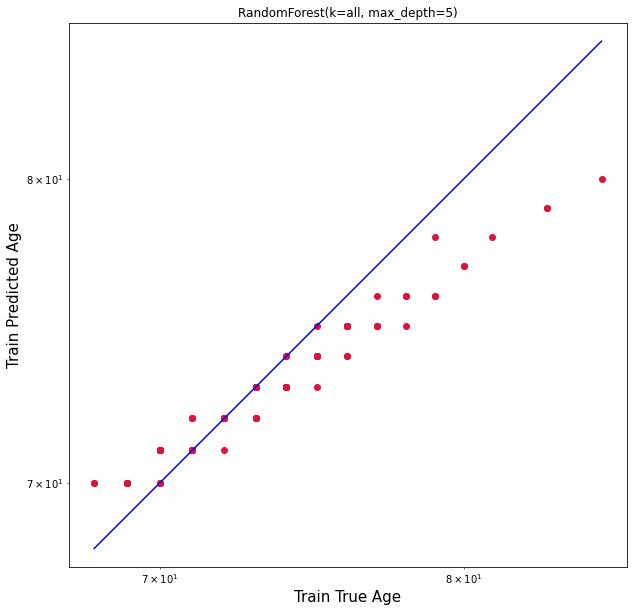

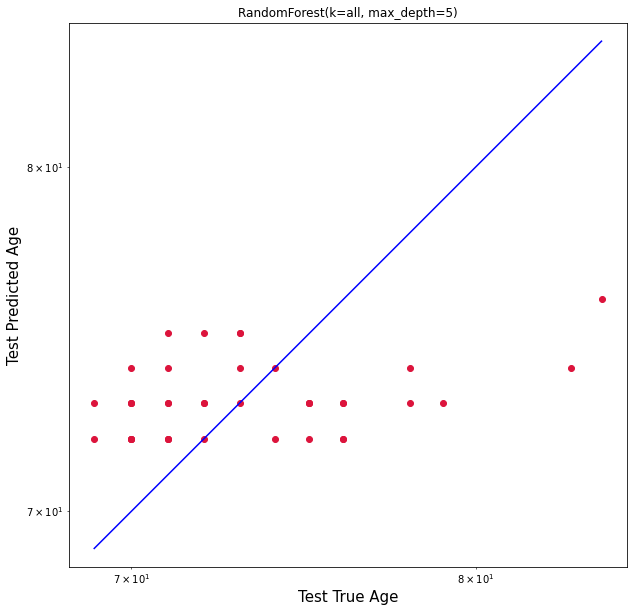

In [38]:
print(poly_x.shape)
random_forest_best = random_forest_search.best_estimator_

# Predict age
predict_train = random_forest_best.predict(x_train)
predict_test = random_forest_best.predict(x_test)

# Compute error
train_error = predict_train - y_train
test_error = predict_test - y_test

train_score = mean_absolute_error(y_train, predict_train)
test_score = mean_absolute_error(y_test, predict_test)

print(f'train_score: {train_score}')
print(f'test_score: {test_score}')

plot_results(y_train, y_test, predict_train, predict_test, {
    'k': random_forest_best.steps[0][1].get_params()["k"],
    'max_depth': random_forest_best.steps[1][1].get_params()["max_depth"]
}, 'RandomForest')

# Kernel Ridge Regression

In [83]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold

In [90]:
poly = PolynomialFeatures(1)
poly_x = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(poly_x, y, test_size=0.3, random_state=42)

# Define pipeline
kernel_pipe = Pipeline(steps=[
    ('select', SelectKBest(f_regression, k=10)),
    ('regressor',  KernelRidge(kernel="sigmoid"))
])

grid = {
    'select__k': [5, 10, 50, 100, 'all'],
    'regressor__alpha': [1e0, 0.1, 1e-2, 1e-3],
    'regressor__gamma': [1e0, 0.1, 1e-2, 1e-3]
}
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

kernel_search = GridSearchCV(kernel_pipe, grid, cv=cv, n_jobs=3, verbose=10, scoring='neg_mean_absolute_error')
kernel_search.fit(x_train, y_train)

Fitting 15 folds for each of 80 candidates, totalling 1200 fits
[CV 3/15; 48/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000
[CV 3/15; 48/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000;, score=nan total time=   0.0s
[CV 4/15; 48/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000
[CV 4/15; 48/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000;, score=nan total time=   0.0s
[CV 5/15; 48/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000
[CV 5/15; 48/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000;, score=nan total time=   0.0s
[CV 6/15; 48/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000
[CV 6/15; 48/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000;, score=nan total time=   0.0s
[CV 7/15; 48/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=10000
[CV 7/15; 48/112] END regressor__alpha=0.1, regressor__

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) 

[CV 12/15; 46/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=100;, score=-9.793 total time=   0.0s
[CV 13/15; 46/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=100
[CV 13/15; 46/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=100;, score=-21.122 total time=   0.0s
[CV 14/15; 46/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=100
[CV 14/15; 46/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=100;, score=-47.022 total time=   0.0s
[CV 15/15; 46/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=100
[CV 15/15; 46/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=100;, score=-12.800 total time=   0.0s
[CV 1/15; 47/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=1000
[CV 1/15; 47/112] END regressor__alpha=0.1, regressor__gamma=0.01, select__k=1000;, score=nan total time=   0.0s
[CV 2/15; 47/112] START regressor__alpha=0.1, regressor__gamma=0.01, select__k=1000


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 8/15; 94/112] START regressor__alpha=0.001, regressor__gamma=0.1, select__k=50
[CV 8/15; 94/112] END regressor__alpha=0.001, regressor__gamma=0.1, select__k=50;, score=-20.569 total time=   0.0s
[CV 9/15; 94/112] START regressor__alpha=0.001, regressor__gamma=0.1, select__k=50
[CV 9/15; 94/112] END regressor__alpha=0.001, regressor__gamma=0.1, select__k=50;, score=-17.964 total time=   0.0s
[CV 10/15; 94/112] START regressor__alpha=0.001, regressor__gamma=0.1, select__k=50
[CV 10/15; 94/112] END regressor__alpha=0.001, regressor__gamma=0.1, select__k=50;, score=-23.115 total time=   0.0s
[CV 11/15; 94/112] START regressor__alpha=0.001, regressor__gamma=0.1, select__k=50
[CV 11/15; 94/112] END regressor__alpha=0.001, regressor__gamma=0.1, select__k=50;, score=-37.480 total time=   0.0s
[CV 12/15; 94/112] START regressor__alpha=0.001, regressor__gamma=0.1, select__k=50
[CV 12/15; 94/112] END regressor__alpha=0.001, regressor__gamma=0.1, select__k=50;, score=-4899.912 total time=   0.

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

[CV 4/15; 111/112] START regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000
[CV 4/15; 111/112] END regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000;, score=nan total time=   0.0s
[CV 5/15; 111/112] START regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000
[CV 5/15; 111/112] END regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000;, score=nan total time=   0.0s
[CV 6/15; 111/112] START regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000
[CV 6/15; 111/112] END regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000;, score=nan total time=   0.0s
[CV 7/15; 111/112] START regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000
[CV 7/15; 111/112] END regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000;, score=nan total time=   0.0s
[CV 8/15; 111/112] START regressor__alpha=0.001, regressor__gamma=0.001, select__k=10000
[CV 8/15; 111/112] END regressor__alpha=0.001, regressor__gamma=0.001, select__k=10

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/pytho

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x15ec01a60>)),
                                       ('regressor',
                                        KernelRidge(kernel='sigmoid'))]),
             n_jobs=3,
             param_grid={'regressor__alpha': [1.0, 0.1, 0.01, 0.001],
                         'regressor__gamma': [1.0, 0.1, 0.01, 0.001],
                         'select__k': [5, 10, 50, 100, 'all']},
             scoring='neg_mean_absolute_error', verbose=10)

In [91]:
print(kernel_search.best_estimator_)
print(kernel_search.best_score_)

Pipeline(steps=[('select',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x15ec01a60>)),
                ('regressor',
                 KernelRidge(alpha=0.1, gamma=0.001, kernel='sigmoid'))])
-2.482214153497391


(133, 297)
train_score: 2.051733997079271
test_score: 1.556953429610315


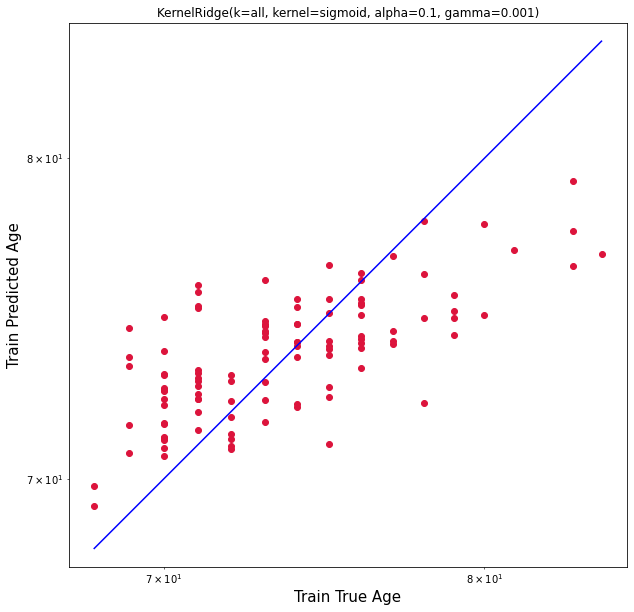

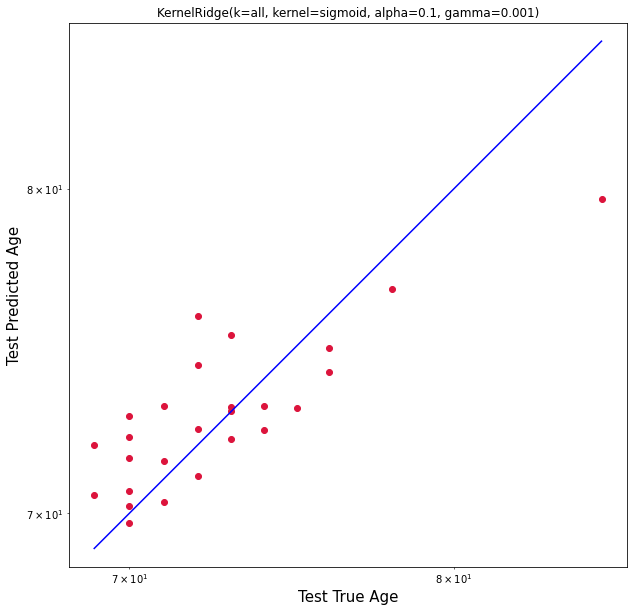

In [133]:
print(poly_x.shape)
kernel_best = kernel_search.best_estimator_

# Predict age
predict_train = kernel_best.predict(x_train)
predict_test = kernel_best.predict(x_test)

# Compute error
train_error = predict_train - y_train
test_error = predict_test - y_test

train_score = mean_absolute_error(y_train, predict_train)
test_score = mean_absolute_error(y_test, predict_test)

print(f'train_score: {train_score}')
print(f'test_score: {test_score}')

plot_results(y_train, y_test, predict_train, predict_test, {
    'k': kernel_best.steps[0][1].get_params()["k"],
    'kernel': 'sigmoid',
    'alpha': kernel_best.steps[1][1].get_params()["alpha"],
    'gamma': kernel_best.steps[1][1].get_params()["gamma"]
}, 'KernelRidge')

# Comparing KernelRidge Sigmoid with Elastic Net

In [164]:
poly = PolynomialFeatures(1)
poly_x = poly.fit_transform(x)

kf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
model = KernelRidge(kernel="sigmoid", alpha=0.1, gamma=0.001)
train_scores = []
test_scores = []
for train_index, test_index in kf.split(poly_x):
    x_train, x_test = poly_x[train_index, :], poly_x[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(x_train, y_train)
    
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    
    train_score = mean_absolute_error(y_train, predict_train)
    test_score = mean_absolute_error(y_test, predict_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    #print(f'train_score: {train_score}')
    #print(f'test_score: {test_score}')

print(f'train_score = {np.mean(train_scores):.2f}')
print(f'   best: {np.min(train_scores):.2f}')
print(f'   worst: {np.max(train_scores):.2f}')
print(f'test_score = {np.mean(test_scores):.2f}')
print(f'   best: {np.min(test_scores):.2f}')
print(f'   worst: {np.max(test_scores):.2f}')
model.fit(poly_x, y)
predict = model.predict(poly_x)
score = mean_absolute_error(y, predict)
print(f'global score = {score:.2f}')

train_score = 1.86
   best: 1.62
   worst: 2.12
test_score = 2.67
   best: 1.80
   worst: 3.36
global score = 2.17


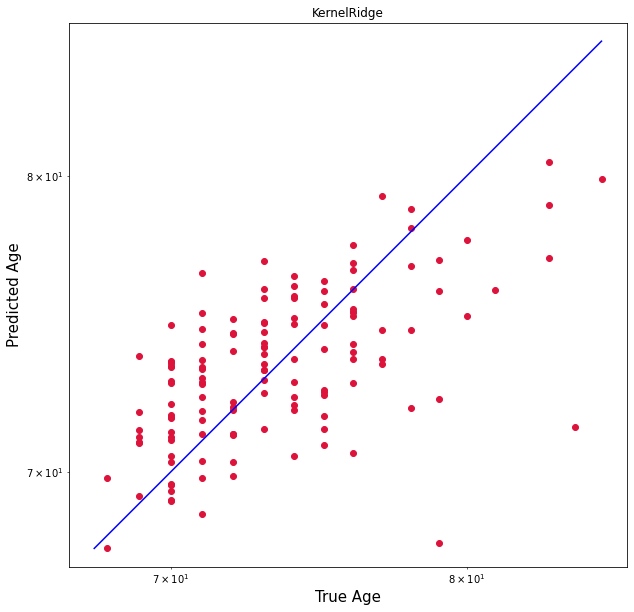

In [165]:
# Plot
plt.figure(figsize=(10,10))
plt.scatter(np.array(y, dtype='int'), predict, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predict), max(y))
p2 = min(min(predict), min(y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Age', fontsize=15)
plt.ylabel('Predicted Age', fontsize=15)
plt.title('KernelRidge')
plt.axis('equal')
plt.show()

In [162]:
poly = PolynomialFeatures(1)
poly_x = poly.fit_transform(x)

kf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
model = ElasticNet(alpha=0.1, l1_ratio=0.0001)
train_scores = []
test_scores = []
for train_index, test_index in kf.split(poly_x):
    x_train, x_test = poly_x[train_index, :], poly_x[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(x_train, y_train)
    
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    
    train_score = mean_absolute_error(y_train, predict_train)
    test_score = mean_absolute_error(y_test, predict_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    #print(f'train_score: {train_score}')
    #print(f'test_score: {test_score}')

print(f'train_score = {np.mean(train_scores):.2f}')
print(f'   best: {np.min(train_scores):.2f}')
print(f'   worst: {np.max(train_scores):.2f}')
print(f'test_score = {np.mean(test_scores):.2f}')
print(f'   best: {np.min(test_scores):.2f}')
print(f'   worst: {np.max(test_scores):.2f}')
model.fit(poly_x, y)
predict = model.predict(poly_x)

score = mean_absolute_error(y, predict)
print(f'global score = {score:.2f}')

train_score = 0.24
   best: 0.18
   worst: 0.27
test_score = 2.73
   best: 1.99
   worst: 3.50
global score = 0.35


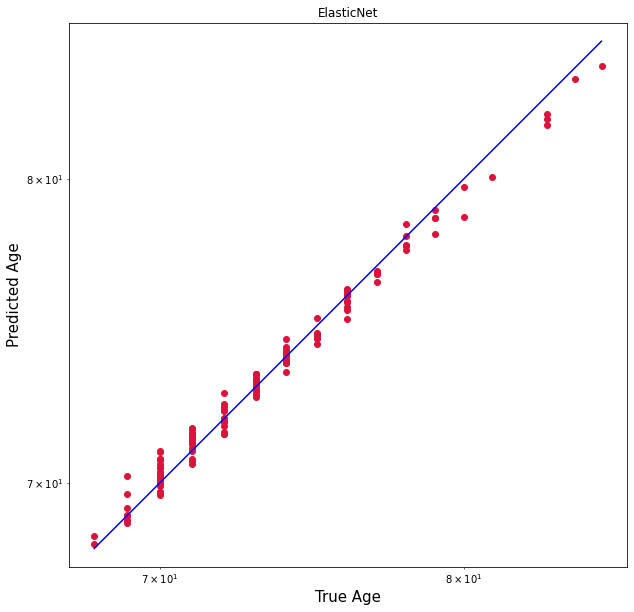

In [163]:
# Plot
plt.figure(figsize=(10,10))
plt.scatter(np.array(y, dtype='int'),predict, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predict), max(y))
p2 = min(min(predict), min(y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Age', fontsize=15)
plt.ylabel('Predicted Age', fontsize=15)
plt.title('ElasticNet')
plt.axis('equal')
plt.show()